загрузим 500 слоев изображений

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
data = np.load('data_vmk21_500.npy')

In [163]:
data[:,:, 0]

array([[  0., 255., 255., ...,  25., 161.,   0.],
       [ 43.,   0., 255., ...,   0., 255., 146.],
       [  0., 131., 210., ..., 227., 208., 128.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 255.],
       [  0.,   0.,   0., ...,   0., 129., 211.],
       [255., 255., 255., ..., 122.,   0.,   0.]])

In [11]:
a, b, c = data.shape
c

500

__________________

сама часть кода

In [2]:
from scipy.special import softmax
import numpy as np
from scipy import signal


def calculate_log_probability(X, F, B, s):
    """
    Calculates log p(X_k|d_k,F,B,s) for all images X_k in X and
    all possible displacements d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(H-h+1, W-w+1, K)
        ll[dh,dw,k] - log-likelihood of observing image X_k given
        that the villain's face F is located at displacement (dh, dw)
    """
    EPS = 10e-9
    H_X, W_X, K_len = X.shape
    h, w = F.shape[0], F.shape[1]

    Res = np.zeros((H_X - h + 1, W_X - w + 1, K_len))
    for i in range(H_X - h + 1):
        for j in range(W_X - w + 1):
            Back = B.copy()
            Back[i:i + h, j:j + w] = F
            Res[i, j, :] = np.sum((X - Back[:, :, np.newaxis]) ** 2, axis=(0, 1))

    return Res * (-1 / (2 * s ** 2)) - (H_X * W_X * np.log(np.sqrt(2 * np.pi) * s))


# ready


def calculate_lower_bound(X, F, B, s, A, q, use_MAP=False):
    """
    Calculates the lower bound L(q,F,B,s,A) for the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    L : float
        The lower bound L(q,F,B,s,A) for the marginal log likelihood.
    """
    EPS = 10e-10
    log_X_d = calculate_log_probability(X, F, B, s)
    if use_MAP == False:
        res = np.sum(q * (log_X_d + np.log(A[:, :, np.newaxis] + EPS))) - np.sum(q * np.log(q + EPS))
    else:
        # shape(2, K)
        #res = np.sum(np.diag(log_X_d[q[0], q[1]]) + np.diag(np.log(A[:, :, np.newaxis] + EPS)[q[0], q[1]]))
        oness = np.ones((A.shape[0], A.shape[1], log_X_d.shape[2]))
        res = np.sum(log_X_d[q[0], q[1], np.arange(log_X_d.shape[2])] + \
                     np.log(A[:, :, np.newaxis]*oness + EPS)[q[0], q[1], np.arange(log_X_d.shape[2])])
    return res


def run_e_step(X, F, B, s, A, use_MAP=False):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k,F,B,s,A).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(h, w)
        Estimate of villain's face.
    B : array shape(H, W)
        Estimate of background.
    s : scalar, shape(1, 1)
        Eestimate of standard deviation of Gaussian noise.
    A : array, shape(H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    use_MAP : bool, optional,
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    """
    # Res * (-1 / s**2) - H_X * W_X* np.log( np. sqrt(2*pi) * s**2)
    EPS = 10e-10
    H_X, W_X, K_len = X.shape

    log_X_d = calculate_log_probability(X, F, B, s)  # + H_X * W_X* np.log( np. sqrt(2*np.pi) * s)
    part = log_X_d + np.log(A[:, :, np.newaxis] + EPS)  # dimention H-h+1 x W-w+1 x K
    # q = softmax(part) # exp (log) -> q

    if use_MAP == False:
        q = softmax(part - np.max(part, axis=(0, 1))[np.newaxis, np.newaxis, :], axis=(0, 1))
    else:
        step = np.argmax(part.reshape(part.shape[0] * part.shape[1], part.shape[2]), axis=0)
        q = np.unravel_index(step, (part.shape[0], part.shape[1]))
        q = np.vstack(q)
    return q


def run_m_step(X, q, h, w, use_MAP=False):
    """
    Estimates F,B,s,A given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    q  :
        if use_MAP = False: array, shape (H-h+1, W-w+1, K)
           q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
           of villain's face given image Xk
        if use_MAP = True: array, shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    h : int
        Face mask height.
    w : int
        Face mask width.
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    """
    EPS = 10e-9
    H_X, W_X, K_len = X.shape

    if use_MAP == False:
        # F
        F = np.sum(signal.fftconvolve(X, q[::-1, ::-1, ], mode='full', axes=(0, 1)) \
                       [q.shape[0] - 1: -(q.shape[0] - 1), q.shape[1] - 1: -(q.shape[1] - 1), :], axis=2)
        F = F / K_len
        # B
        oness = np.ones((h, w))[:, :, np.newaxis]
        part_m = signal.fftconvolve(q, oness, mode='full')
        B = np.sum(X * (1 - part_m), axis=-1) / (np.sum(1 - part_m, axis=-1) + EPS)
        # s
        step = calculate_log_probability(X, F, B, 1)
        Q = (step + H_X * W_X * np.log(np.sqrt(2 * np.pi) * 1)) / (-1 / 2)
        s_2 = np.sum(q * Q) / (H_X * W_X * K_len)
        # A
        A = np.sum(q, axis=-1) / K_len

        # mask_ones = np.ones((h, w))[:, :, np.newaxis]
        # q_clust = signal.fftconvolve(q, mask_ones, mode='full')
        # B = np.sum((1-q_clust) * X, axis=2) / (np.sum(1-q_clust, axis=2)+eps)




    else:
        # F
        ccheck = np.zeros((h, w, K_len))
        for i in range(X.shape[2]):
            ccheck[:, :, i] = X[q[0][i]:q[0][i] + h, q[1][i]:q[1][i] + w, i]
        F = np.sum(ccheck, axis=-1) / K_len
        # B
        check_B = np.ones((H_X, W_X, K_len))
        for i in range(X.shape[2]):
            # first_h = max(0, q[0][i] - h + 1)
            # first_w = max(0, q[1][i] - w + 1)
            # last_h = min(H_X-h, q[0][i])
            # last_w = min(W_X-w, q[1][i])
            # check_B[first_h:q[0][i] + h, first_w:q[1][i] + w, i] = 0
            check_B[q[0][i]:q[0][i] + h, q[1][i]:q[1][i] + w, i] = 0
        B = np.sum(X * check_B, axis=-1) / (np.sum(check_B, axis=-1) + EPS)
        # s
        step = calculate_log_probability(X, F, B, 1)
        Q = (step + H_X * W_X * np.log(np.sqrt(2 * np.pi) * 1)) / (-1 / 2)
        s_2 = np.sum(np.diag(Q[q[0], q[1]])) / (H_X * W_X * K_len)
        # A
        A = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
        # r[q[0], q[1]] += 1 не работает на пересечениях
        for i in range(X.shape[2]):
            A[q[0][i], q[1][i]] += 1
        A = A / X.shape[2]

    return F, B, np.sqrt(s_2), A


def run_EM(X, h, w, F=None, B=None, s=None, A=None, tolerance=0.001,
           max_iter=5, use_MAP=False):
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    F : array, shape (h, w), optional
        Initial estimate of villain's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1), optional
        Initial estimate of prior on displacement of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.
    use_MAP : bool, optional
        If true then after E-step we take only MAP estimates of displacement
        (dh,dw) of villain's face given image Xk.

    Returns
    -------
    F, B, s, A : trained parameters.
    LL : array, shape(number_of_iters,)
        L(q,F,B,s,A) after each EM iteration (1 iteration = 1 e-step + 1 m-step);
        number_of_iters is actual number of iterations that was done.
    """

    if F is None:
        F = np.zeros((h, w))
    if B is None:
        B = np.random.rand(X.shape[0], X.shape[1])
    if s is None:
        s = 0.25
    if A is None:
        A = np.random.rand(X.shape[0] - h + 1, X.shape[1] - w + 1)
        A /= A.sum()
    check = 1
    L_old = -np.inf
    mass = []
    i = 0
    while check == 1 and i < max_iter:
        i += 1
        q = run_e_step(X, F, B, s, A, use_MAP)
        F, B, s, A = run_m_step(X, q, h, w, use_MAP)
        L_new = calculate_lower_bound(X, F, B, s, A, q, use_MAP)
        if abs(L_new - L_old) < tolerance:
            check = 0
        L_old = L_new
        mass += [L_old]

    return F, B, s, A, mass


# ready


def run_EM_with_restarts(X, h, w, tolerance=0.001, max_iter=50, use_MAP=False,
                         n_restarts=10):
    """
    Restarts EM several times from different random initializations
    and stores the best estimate of the parameters as measured by
    the L(q,F,B,s,A).

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    tolerance, max_iter, use_MAP : optional parameters for EM.
    n_restarts : int
        Number of EM runs.

    Returns
    -------
    F : array,  shape (h, w)
        The best estimate of villain's face.
    B : array, shape (H, W)
        The best estimate of background.
    s : float
        The best estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        The best estimate of prior on displacement of face in any image.
    L : float
        The best L(q,F,B,s,A).
    """
    L_best = [-np.inf]
    L_new = -np.inf
    for i in range(n_restarts):

        F_new, B_new, s_new, A_new, L_new = run_EM(X, h, w, None, None, None, None, tolerance, max_iter, use_MAP)
        if L_new[-1] > L_best[-1]:
            F_best, B_nest, s_best, A_best, L_best = F_new, B_new, s_new, A_new, L_new

    return F_best, B_nest, s_best, A_best, L_best

In [1063]:
H, W, K = 30, 40, 50
h, w = 10, 15

B = np.zeros((H, W))
F = np.ones((h, w))
s = 1.0

np.random.seed(1)
noize = np.random.randn(H, W, K)
coords_0 = np.random.randint(0, H-h+1, K)
coords_1 = np.random.randint(0, W-w+1, K)

X = np.zeros((H, W, K))

for k in range(K):
    X[coords_0[k]: coords_0[k] + h, coords_1[k]: coords_1[k]+w, k] = F.copy()

X += noize
X = np.clip(X, 0, 1)

F_init = np.random.rand(h, w)
B_init = np.random.rand(H, W)
s_init = 0.5
A_init = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))
#q = run_e_step(X, F_init, B_init, s_init, A_init, use_MAP=True)
#run_m_step(X, q, h, w, use_MAP=True)
FF, BB, ss, AA, LL = run_EM(X, h, w, F_init, B_init, s_init, A_init, max_iter=50, use_MAP=True)

In [1064]:
LL

[-31797.03908770854,
 -31668.773490280466,
 -31651.773071126398,
 -31642.479295383906,
 -31633.91591776868,
 -31609.59116183886,
 -31578.422754956704,
 -31524.71316677172,
 -31511.587110590346,
 -31502.882522261665,
 -31502.882522261665]

In [952]:
H, W, K = 3, 4, 5
h, w = 2, 3

B = np.zeros((H, W))
F = np.ones((h, w))
s = 1.0

np.random.seed(1)
noize = np.random.randn(H, W, K)
coords_0 = np.random.randint(0, H-h+1, K)
coords_1 = np.random.randint(0, W-w+1, K)

X = np.zeros((H, W, K))

for k in range(K):
    X[coords_0[k]: coords_0[k] + h, coords_1[k]: coords_1[k]+w, k] = F.copy()

X += noize
X = np.clip(X, 0, 1)

F_init = np.random.rand(h, w)
B_init = np.random.rand(H, W)
s_init = 0.5
A_init = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))
q = run_e_step(X, F_init, B_init, s_init, A_init, use_MAP=False)
run_m_step(X, q, h, w, use_MAP=False)
#FF, BB, ss, AA, LL = run_EM(X, h, w, F_init, B_init, s_init, A_init, max_iter=50, use_MAP=True)

(array([[0.78863773, 0.51533593, 0.48177031],
        [0.3042499 , 0.45327961, 0.3497708 ]]),
 array([[3.58221045e-01, 6.88730486e-01, 5.58143376e-01, 1.61032488e-01],
        [7.90697491e-01, 7.02265210e-09, 1.02697596e-08, 4.56131777e-01],
        [5.24835893e-01, 4.88515142e-01, 2.90186637e-01, 7.59057725e-01]]),
 0.36687839006241907,
 array([[0.21789816, 0.26355928],
        [0.33764037, 0.18090219]]))

In [833]:
type(data[:,:, 0])

numpy.ndarray

In [791]:
from PIL import Image

In [792]:
im = Image.fromarray(data[40:50,40:50, 7])

In [261]:
data[40:50,40:50, 7]

array([[  0.,  14.,   0.,   0., 151., 255.,   0., 204., 255., 255.],
       [ 86., 119., 255.,  63., 255.,  33.,  40.,   0., 223.,   0.],
       [  0., 175., 255., 225., 255.,  76.,   0.,   0.,   0., 255.],
       [255., 255., 216., 255.,   0., 207., 255., 146.,   0., 255.],
       [255.,   0., 196., 255.,   0., 255.,   0., 218.,  98., 255.],
       [173., 255., 129.,   0.,   0., 226.,   0., 163., 255.,   0.],
       [255., 255.,   0., 255., 255., 255.,   0., 220.,   0., 255.],
       [255., 255.,   0.,   0.,   0., 255., 255.,   0., 150., 255.],
       [  0., 255., 224.,   0., 201.,   0., 255., 255.,   0.,  89.],
       [255.,  58.,   0., 255.,  11., 255.,  70.,   0.,   0., 255.]])

In [269]:
type(data)

numpy.ndarray

In [262]:
#im.show()

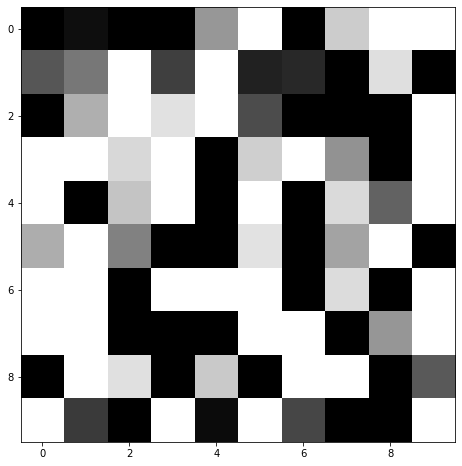

In [263]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(im)

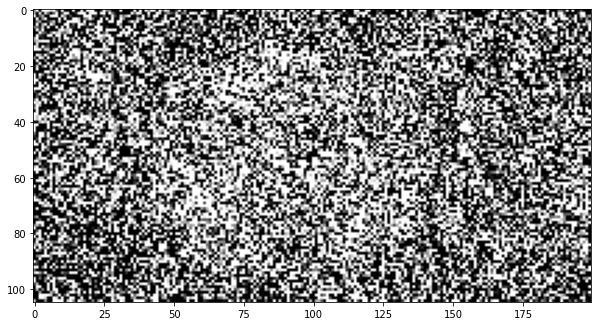

In [1144]:
im = Image.fromarray(data[:,:, 100])
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(im)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/data_example.pdf')

## тесты ##

In [914]:
import sys
import time
import numpy as np
from nose.tools import ok_, eq_
from numpy.testing import assert_almost_equal
#import Student as model


def test_python3():
    ok_(sys.version_info > (3, 3))


def check_shape(**kwargs):
    np.random.seed(42)
    H, W, K = 10, 12, 20
    h, w = 4, 5
    max_iter = 1
    X = np.random.rand(H, W, K)
    F, B, s, A, LL = run_EM(X, h, w, max_iter=max_iter, **kwargs)
    eq_(F.shape, (h, w))
    eq_(B.shape, (H, W))
    eq_(A.shape, (H-h+1, W-w+1))
    eq_(np.array(LL).shape, (max_iter,))


def generate_data(H, W, K, h, w, use_MAP=False, seed=42):
    # explicit data with no noise
    np.random.seed(seed)
    X = np.zeros((H, W, K))
    F = np.zeros((h, w))
    B = np.random.rand(H, W)

    coords = []
    q = np.zeros((H-h+1, W-w+1, K))
    for k in range(K):
        x = np.random.randint(0, H-h+1)
        y = np.random.randint(0, W-w+1)
        coords.append((x, y))
        X[:, :, k] = np.copy(B)
        X[x:x+h, y:y+w, k] = F
        q[x, y, k] = 1.

    A = np.random.rand(H - h + 1, W - w + 1)
    A /= A.sum()

    if use_MAP:
        q = np.array(coords).T

    return X, F, B, A, q


def check_e_step(use_MAP=False):
    H, W, K = 4, 5, 2
    h, w = 2, 3
    s = 1e-1
    X, F, B, A, q = \
        generate_data(H, W, K, h, w, use_MAP=use_MAP)

    pred_q = run_e_step(X, F, B, s, A, use_MAP=use_MAP)
    if use_MAP:
        assert_almost_equal(q, pred_q)
    else:
        assert_almost_equal(q, pred_q, 5)


def check_m_step(use_MAP=False):
    H, W, K = 7, 8, 2
    h, w = 2, 3
    X, F, B, A, q = generate_data(H, W, K, h, w, use_MAP=use_MAP)

    pred_F, pred_B, pred_s, pred_A = \
        run_m_step(X, q, h, w, use_MAP=use_MAP)

    assert_almost_equal(F, pred_F)
    assert_almost_equal(B, pred_B)


def check_e_step_time(use_MAP=False):
    H, W, K = 50, 100, 50
    h, w = 40, 50
    s = 0.1
    X, F, B, A, q = generate_data(H, W, K, h, w)
    t_start = time.perf_counter()
    run_e_step(X, F, B, s, A, use_MAP=use_MAP)
    computation_time = time.perf_counter() - t_start
    assert computation_time < 1


def check_m_step_time(use_MAP=False):
    H, W, K = 50, 100, 50
    h, w = 40, 50
    X, F, B, A, q = generate_data(H, W, K, h, w, use_MAP=use_MAP)

    t_start = time.perf_counter()
    run_m_step(X, q, h, w, use_MAP=use_MAP)
    computation_time = time.perf_counter() - t_start
    assert computation_time < 1


def test_output_shape():
    check_shape()
    check_shape(use_MAP=True)


def test_e_step():
    check_e_step()
    check_e_step(use_MAP=True)


def test_m_stap():
    check_m_step()
    check_m_step(use_MAP=True)


def test_e_step_time():
    check_e_step_time()
    check_e_step_time(use_MAP=True)


def test_m_step_time():
    check_m_step_time()
    check_m_step_time(use_MAP=True)

In [915]:
test_output_shape()

In [916]:
test_e_step()

In [917]:
test_m_stap()

In [918]:
test_e_step_time()

AssertionError: 

In [ ]:
test_m_step_time()

In [162]:
#generate_data()

In [3]:
path = r"C:\Users\User\Jupiter_notebook\байес_7сем\s_1_7.png"

In [4]:
from PIL import Image, ImageDraw
img = Image.open(path)#.convert('LA')

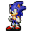

In [5]:
img

In [6]:
img.size

(32, 32)

In [7]:
img = np.array(img)
img[10, 10]

array([221, 224, 192, 255], dtype=uint8)

In [8]:
face = img[6:27, 8:23, 0]
face = np.array(face) * 1.3
face.shape

(21, 15)

In [9]:
face = face / 255

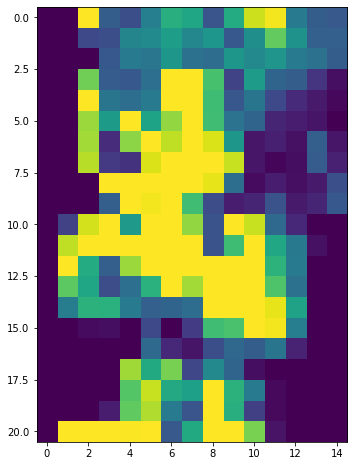

In [10]:
im_gray = Image.fromarray(face)
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(face, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/sonic.pdf')

In [11]:
back_ground = np.zeros((30, 40))
for i in range(30):
    back_ground[i, :] = (i * 8) % 256
    #    if (3 < i < 8) and (20 < j < 25) or (20 < i < 25) and (2 < j < 8) or (20 < i < 25) and (28 < j < 35):
    #        back_ground[i, j] = 255
    #    else:
    #        back_ground[i, j] = 0
back_ground = back_ground / 255

back_ground.shape

(30, 40)

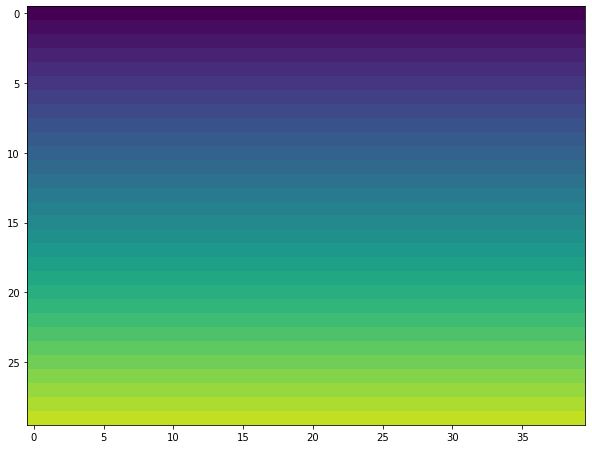

In [12]:
im_back = Image.fromarray(back_ground)
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(back_ground, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/back_exmpl.pdf')

In [1225]:
back_ground_2 = np.zeros((30, 40))
for i in range(30):
    back_ground_2[i, :] = 255
back_ground_2 = back_ground_2 / 255
back_ground_2.shape

(30, 40)

In [1226]:
#back_ground_2

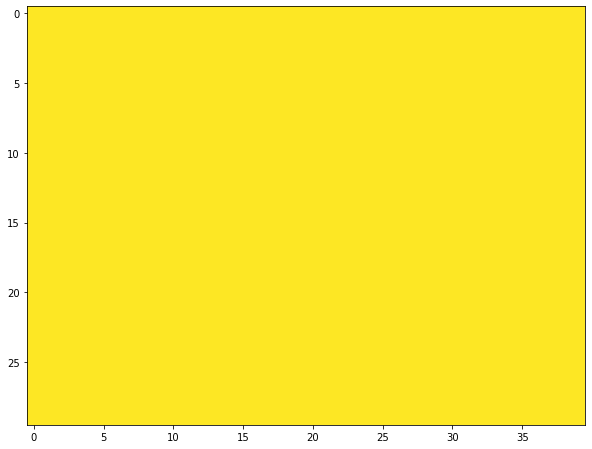

In [1227]:
im_back = Image.fromarray(back_ground)
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(back_ground_2, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/back_yellow.pdf')

In [51]:
#H, W, K = 25, 30, 500
import time

start_time = time.time()

H, W, K = 30, 40, 80
h, w = 21, 15
B = back_ground
F = face
s = 0.1

np.random.seed(1)
noize = np.random.randn(H, W, K)
coords_0 = np.random.randint(0, H-h+1, K)
coords_1 = np.random.randint(0, W-w+1, K)

X = np.zeros((H, W, K))

for k in range(K):
    X[coords_0[k]: coords_0[k] + h, coords_1[k]: coords_1[k]+w, k] = F.copy()

X += noize
X = np.clip(X, 0, 1)

F_init = np.random.rand(h, w)
#F_init = np.zeros((h, w))
#B_init = np.random.rand(H, W)
B_init = np.zeros((H, W))
s_init = 0.5
A_init = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))
#q = run_e_step(X, F_init, B_init, s_init, A_init, use_MAP=False)
#run_m_step(X, q, h, w, use_MAP=False)
FF, BB, ss, AA, LL = run_EM(X, h, w, F_init, B_init, s_init, A_init, max_iter=50, use_MAP=False)
time_re = time.time() - start_time

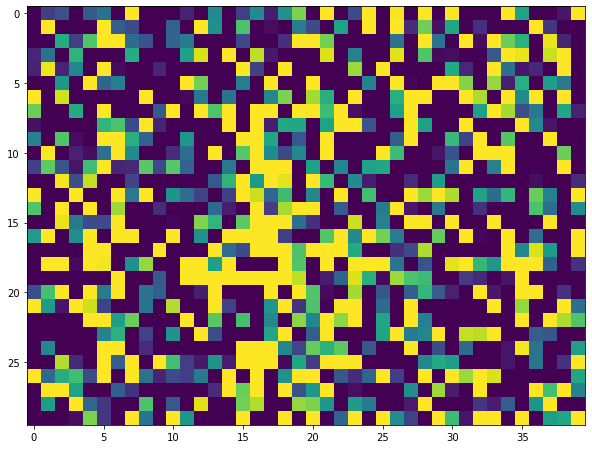

In [56]:
im_back = Image.fromarray(back_ground)
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(X[:,:,2], vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/back_yellow.pdf')

In [37]:
time_re

10.391721487045288

In [15]:
LL

[-63626.61581952924,
 -63300.25266544679,
 -62909.98840309603,
 -61781.497257888346,
 -61224.66863151321,
 -61025.14819125548,
 -60882.079272505565,
 -60788.14390533291,
 -60712.57993624475,
 -60688.163872349855,
 -60663.94774623622,
 -60652.6010114929,
 -60644.73659422107,
 -60631.884718787136,
 -60620.34986679738,
 -60602.42761911638,
 -60587.37206675913,
 -60583.837698242976,
 -60573.82360861796,
 -60558.01481659109,
 -60553.25088859339,
 -60540.03601759638,
 -60526.85589468892,
 -60514.200053847446,
 -60497.24558482654,
 -60479.56701500743,
 -60477.77973787454,
 -60474.9913715285,
 -60463.17944875008,
 -60447.25190788029,
 -60433.78174474217,
 -60430.41876318419,
 -60422.963297617796,
 -60419.649615155955,
 -60414.51440325727,
 -60412.97525679429,
 -60406.1053548425,
 -60398.48261833849,
 -60393.233076871154,
 -60386.06675106499,
 -60379.193842746725,
 -60371.19802063047,
 -60355.24103942994,
 -60352.10184048265,
 -60344.69726575519,
 -60334.44873420176,
 -60333.23732539141,
 -6032

_____________________

-90739.06242891552 30 40 150 false 15s старт с нуля тот же результат F

-60314.169862465875 30 40 100 false, 9s

-90734.18022914998 30 40 150 false 57s

-121316.76141924865 30 40 200 false 70s

-188645.34419586122 30 40 300 false , 99s

------------------------------

-122661.10856194007 30 40 200 True 10s

-188888.2358465295 30 40 300 True 26s

-246702.35222986306 - 30 40 400 True 91s

________________________

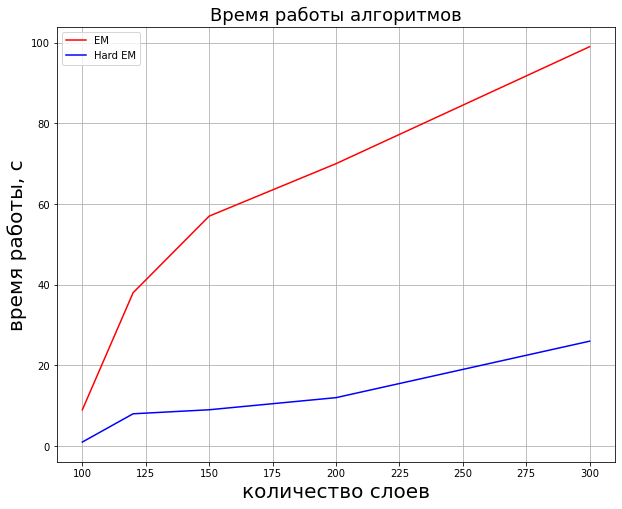

In [1489]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.plot([100, 120, 150, 200, 300], [9, 38, 57, 70, 99], color = 'r', label = 'EM')
ax.plot([100, 120, 150, 200, 300], [1, 8, 9, 12, 26], color = 'b', label = 'Hard EM')

ax.set_ylabel('время работы, с', size = 20)
ax.set_xlabel('количество слоев', size = 20)
ax.legend()
ax.grid()

ax.set_title('Время работы алгоритмов', size = 18 )
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/compare.pdf')
plt.show()

In [1330]:
#FF

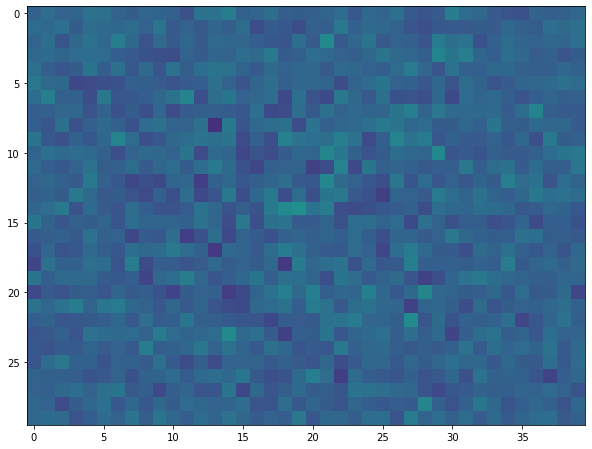

In [16]:
im_res = Image.fromarray(FF)
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(BB, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/res_grad_300_true.pdf')

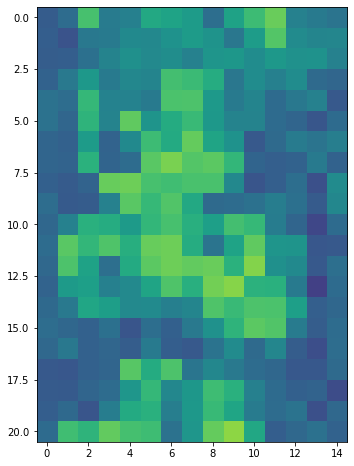

In [52]:
im_res = Image.fromarray(FF)
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(FF, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/sonic_30_40_200_false.pdf')

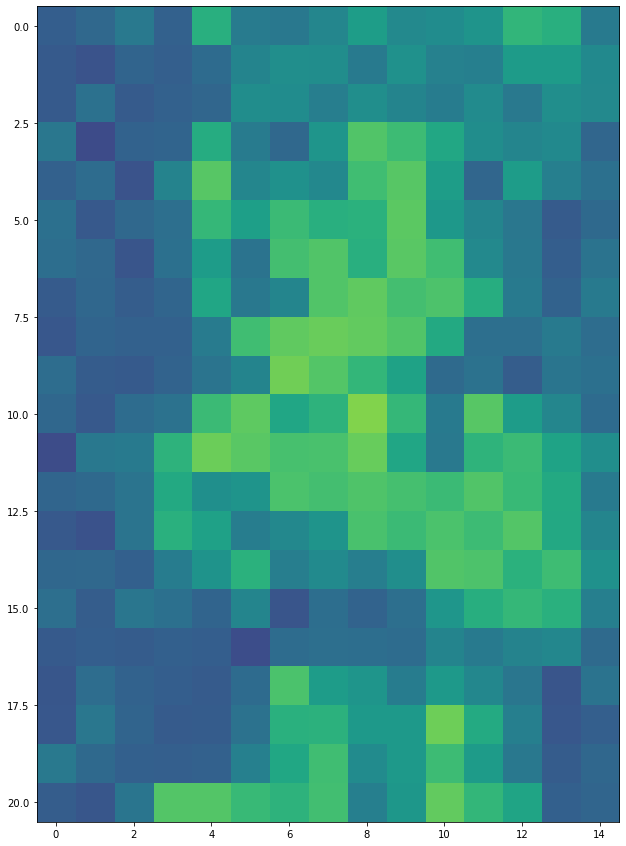

In [1494]:
im_res = Image.fromarray(FF)
fig, ax = plt.subplots(figsize = (20, 15))

plt.imshow(FF, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/sonic_30_40_150_false_zeros_start.pdf')

----------------------

In [1114]:
data_maxim  = data / 255

In [1115]:
data_maxim.shape

(105, 200, 500)

In [1122]:
H, W = 105, 200
h = 100
w = 66

F_init = np.random.rand(h, w)
B_init = np.random.rand(H, W)
s_init = 0.5
A_init = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))
#q = run_e_step(X, F_init, B_init, s_init, A_init, use_MAP=False)
#run_m_step(X, q, h, w, use_MAP=False)
FF_m, BB_m, ss_m, AA_m, LL_m = run_EM(data_maxim, h, w, F_init, B_init, s_init, A_init, max_iter=50, use_MAP=True)

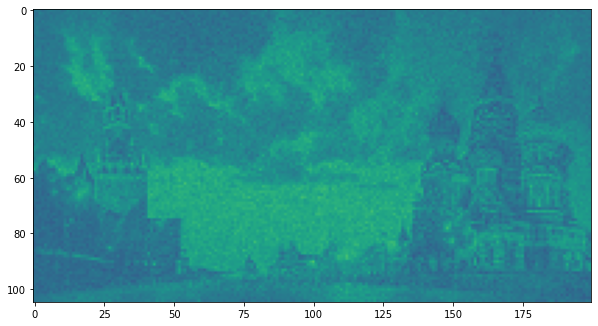

In [1126]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(BB_m, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/krasnaya_500.pdf')

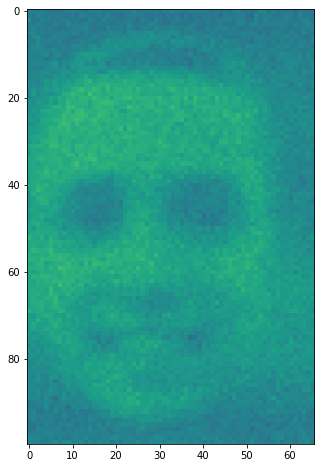

In [1127]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(FF_m, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/face_500.pdf')

In [1130]:
H, W = 105, 200
h = 100
w = 66

F_init = np.random.rand(h, w)
B_init = np.random.rand(H, W)
s_init = 0.5
A_init = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))
#q = run_e_step(X, F_init, B_init, s_init, A_init, use_MAP=False)
#run_m_step(X, q, h, w, use_MAP=False)
run_EM_with_restarts(X, h, w, tolerance=0.001, max_iter=50, use_MAP=False,
                         n_restarts=10):
FF_r50, BB_r50,ss_r50,AA_r50,LL_r50 =run_EM_with_restarts(data_maxim[:,:, :50],h,w,F_init, B_init, s_init, A_init, max_iter=50, use_MAP=True)

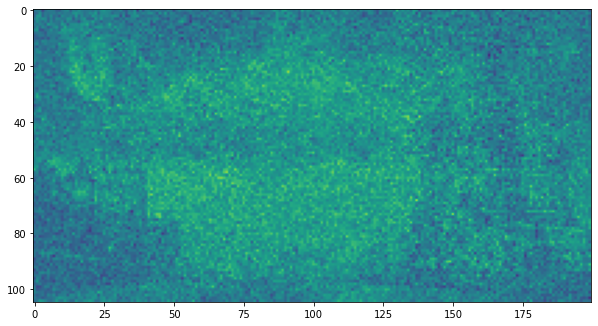

In [1134]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(BB_m50, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/krasnaya_50.pdf')

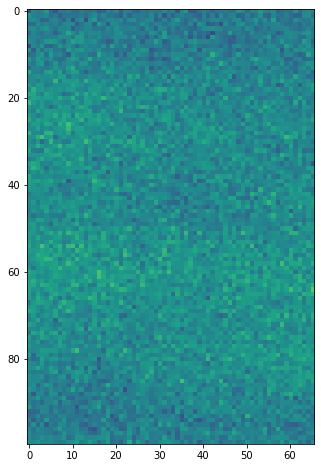

In [1133]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(FF_m50, vmin = 0, vmax = 1)
#plt.savefig('C:/Users/User/Jupiter_notebook/байес_7сем/face_50.pdf')

In [1140]:
H, W = 105, 200
h = 100
w = 66

F_init = np.random.rand(h, w)
B_init = np.random.rand(H, W)
s_init = 0.5
A_init = np.ones((H - h + 1, W - w + 1)) / ((H - h + 1) * (W - w + 1))
#q = run_e_step(X, F_init, B_init, s_init, A_init, use_MAP=False)
#run_m_step(X, q, h, w, use_MAP=False)
FF_r50, BB_r50,ss_r50,AA_r50,LL_r50 =run_EM_with_restarts(data_maxim[:,:, :50], \
                                                          h,w,tolerance=0.001, max_iter=50, use_MAP=True, n_restarts=3)

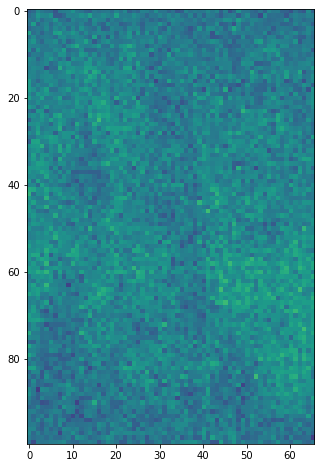

In [1141]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(FF_r50, vmin = 0, vmax = 1)

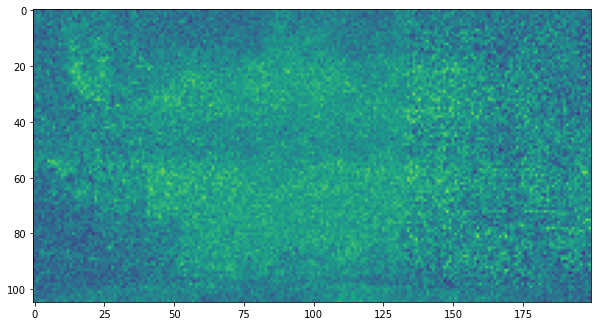

In [1142]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.imshow(BB_r50, vmin = 0, vmax = 1)

In [ ]:
F = np.zeros((h, w))